Goal:
Build an image classifier using MobileNetV2 for pest classification.

ML workflow — Data Prep → Model Building → Training → Evaluation → Saving.

Mount Google Drive, install required packages, import libraries

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages (if needed)
# !pip install tensorflow --upgrade  # Uncomment if TensorFlow version is outdated

# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Mounted at /content/drive


Data Preparation & Preprocessing

Load the dataset from Drive and prepare it using ImageDataGenerator with augmentations and preprocessing for MobileNetV2.

In [ ]:
# Define paths
train_dir = "/content/drive/MyDrive/Pest/Dataset/pest_dataset/train"
val_dir = "/content/drive/MyDrive/Pest/Dataset/pest_dataset/val"

# Image size for MobileNetV2
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Augmentation & Preprocessing for MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Save class labels for reference
class_labels = list(train_data.class_indices.keys())
print("Class labels:", class_labels)


Found 3076 images belonging to 14 classes.
Found 770 images belonging to 14 classes.
Class labels: ['ants', 'bees', 'beetle', 'caterpillar', 'earthworms', 'earwig', 'grasshopper', 'healthy', 'moth', 'slug', 'snail', 'train', 'wasp', 'weevil']


Build the MobileNetV2 Model
Use MobileNetV2 as the feature extractor, add custom layers on top, and compile the model.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model (without top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers (they won't be updated during training)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Convert feature maps to a single 1D vector
x = Dropout(0.3)(x)                 # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)  # Output layer

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,758 (9.25 MB)

 Trainable params: 165,774 (647.55 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model with Callbacks
Train the model using the training and validation sets, and include callbacks like:

ModelCheckpoint – saves the best model.

EarlyStopping – stops training if val_loss doesn’t improve.

ReduceLROnPlateau – lowers learning rate when plateauing.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# Set the paths to your image folders
train_dir = "/content/drive/MyDrive/Pest/Dataset/pest_dataset/train"
val_dir = "/content/drive/MyDrive/Pest/Dataset/pest_dataset/val"
# Image data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3076 images belonging to 14 classes.
Found 770 images belonging to 14 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint("mobilenetv2_best_model.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)

early_stop = EarlyStopping(monitor="val_loss",
                           patience=5,
                           restore_best_weights=True,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.1632 - loss: 2.7657 
Epoch 1: val_accuracy improved from -inf to 0.62078, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 1785s 18s/step - accuracy: 0.1641 - loss: 2.7620 - val_accuracy: 0.6208 - val_loss: 1.5666 - learning_rate: 1.0000e-04
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4627 - loss: 1.7406
Epoch 2: val_accuracy improved from 0.62078 to 0.75584, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.4631 - loss: 1.7393 - val_accuracy: 0.7558 - val_loss: 1.0372 - learning_rate: 1.0000e-04
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6120 - loss: 1.2781
Epoch 3: val_accuracy improved from 0.75584 to 0.80779, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.6121 - loss: 1.2777 - val_accuracy: 0.8078 - val_loss: 0.7595 - learning_rate: 1.0000e-04
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6731 - loss: 1.0514
Epoch 4: val_accuracy improved from 0.80779 to 0.82987, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.6730 - loss: 1.0513 - val_accuracy: 0.8299 - val_loss: 0.6377 - learning_rate: 1.0000e-04
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7320 - loss: 0.8879
Epoch 5: val_accuracy improved from 0.82987 to 0.83636, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.7321 - loss: 0.8878 - val_accuracy: 0.8364 - val_loss: 0.5686 - learning_rate: 1.0000e-04
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7496 - loss: 0.8181
Epoch 6: val_accuracy improved from 0.83636 to 0.85065, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.7496 - loss: 0.8179 - val_accuracy: 0.8506 - val_loss: 0.5175 - learning_rate: 1.0000e-04
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7812 - loss: 0.7168
Epoch 7: val_accuracy improved from 0.85065 to 0.85455, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7812 - loss: 0.7170 - val_accuracy: 0.8545 - val_loss: 0.4797 - learning_rate: 1.0000e-04
Epoch 8/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7799 - loss: 0.7062
Epoch 8: val_accuracy improved from 0.85455 to 0.85714, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7800 - loss: 0.7062 - val_accuracy: 0.8571 - val_loss: 0.4618 - learning_rate: 1.0000e-04
Epoch 9/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8085 - loss: 0.6253
Epoch 9: val_accuracy improved from 0.85714 to 0.87273, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.8084 - loss: 0.6255 - val_accuracy: 0.8727 - val_loss: 0.4436 - learning_rate: 1.0000e-04
Epoch 10/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7923 - loss: 0.6587
Epoch 10: val_accuracy did not improve from 0.87273
97/97 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7923 - loss: 0.6584 - val_accuracy: 0.8675 - val_loss: 0.4298 - learning_rate: 1.0000e-04
Epoch 11/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7886 - loss: 0.6519
Epoch 11: val_accuracy did not improve from 0.87273
97/97 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.7887 - loss: 0.6516 - val_accuracy: 0.8610 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 12/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8094 - loss: 0.5824
Epoch 12: val_accuracy improved from 0.87273 to 0.87403, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.8094 - loss: 0.5824 - val_accuracy: 0.8740 - val_loss: 0.4052 - learning_rate: 1.0000e-04
Epoch 13/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8138 - loss: 0.5645
Epoch 13: val_accuracy did not improve from 0.87403
97/97 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8139 - loss: 0.5644 - val_accuracy: 0.8740 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 14/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8193 - loss: 0.5758
Epoch 14: val_accuracy improved from 0.87403 to 0.87922, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.8193 - loss: 0.5758 - val_accuracy: 0.8792 - val_loss: 0.3947 - learning_rate: 1.0000e-04
Epoch 15/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8329 - loss: 0.5178
Epoch 15: val_accuracy did not improve from 0.87922
97/97 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8328 - loss: 0.5180 - val_accuracy: 0.8753 - val_loss: 0.3933 - learning_rate: 1.0000e-04
Epoch 16/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8395 - loss: 0.5031
Epoch 16: val_accuracy did not improve from 0.87922
97/97 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.8394 - loss: 0.5032 - val_accuracy: 0.8792 - val_loss: 0.3828 - learning_rate: 1.0000e-04
Epoch 17/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8284 - loss: 0.5155
Epoch 17: val_accuracy did not improve from 0.87922
97/97 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8284 - loss: 0.5156 - val_accuracy: 0.8779 - val_loss: 0.3793 - learning_rate: 1.0000e-04
Epoch 18/30
97/9

97/97 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8470 - loss: 0.4697 - val_accuracy: 0.8831 - val_loss: 0.3780 - learning_rate: 1.0000e-04
Epoch 19/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8413 - loss: 0.5114
Epoch 19: val_accuracy did not improve from 0.88312
97/97 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.8413 - loss: 0.5112 - val_accuracy: 0.8727 - val_loss: 0.3773 - learning_rate: 1.0000e-04
Epoch 20/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8539 - loss: 0.4722
Epoch 20: val_accuracy did not improve from 0.88312
97/97 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8539 - loss: 0.4723 - val_accuracy: 0.8779 - val_loss: 0.3672 - learning_rate: 1.0000e-04
Epoch 21/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8455 - loss: 0.4733
Epoch 21: val_accuracy improved from 0.88312 to 0.88701, saving model to mobilenetv2_best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8455 - loss: 0.4734 - val_accuracy: 0.8870 - val_loss: 0.3698 - learning_rate: 1.0000e-04
Epoch 22/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8574 - loss: 0.4445
Epoch 22: val_accuracy did not improve from 0.88701
97/97 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8573 - loss: 0.4446 - val_accuracy: 0.8831 - val_loss: 0.3622 - learning_rate: 1.0000e-04
Epoch 23/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8523 - loss: 0.4519
Epoch 23: val_accuracy did not improve from 0.88701
97/97 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.8523 - loss: 0.4519 - val_accuracy: 0.8857 - val_loss: 0.3582 - learning_rate: 1.0000e-04
Epoch 24/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8647 - loss: 0.4110
Epoch 24: val_accuracy did not improve from 0.88701
97/97 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8646 - loss: 0.4112 - val_accuracy: 0.8818 - val_loss: 0.3573 - learning_rate: 1.0000e-04
Epoch 25/30
97/9

97/97 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.8572 - loss: 0.4512 - val_accuracy: 0.8961 - val_loss: 0.3475 - learning_rate: 1.0000e-04
Epoch 26/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8532 - loss: 0.4393
Epoch 26: val_accuracy did not improve from 0.89610
97/97 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8533 - loss: 0.4392 - val_accuracy: 0.8870 - val_loss: 0.3551 - learning_rate: 1.0000e-04
Epoch 27/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8671 - loss: 0.4237
Epoch 27: val_accuracy did not improve from 0.89610
97/97 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8670 - loss: 0.4238 - val_accuracy: 0.8922 - val_loss: 0.3445 - learning_rate: 1.0000e-04
Epoch 28/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8665 - loss: 0.4092
Epoch 28: val_accuracy did not improve from 0.89610
97/97 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8664 - loss: 0.4093 - val_accuracy: 0.8831 - val_loss: 0.3531 - learning_rate: 1.0000e-04
Epoch 29/30
97/9

Save the model

In [ ]:
# Save model in HDF5 format
model.save('mobilenetv2_pest_classifier.h5')


In [ ]:
model.save('mobilenetv2_pest_classifier.h5')  # creates a folder with model and assets


Loading model

In [ ]:
from tensorflow.keras.models import load_model

# For HDF5
model = load_model('mobilenetv2_pest_classifier.h5')

# For SavedModel
# model = load_model('mobilenetv2_pest_classifier')


Checking Validation Accuracy

In [ ]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8742 - loss: 0.3983
Validation Accuracy: 89.22%
Validation Loss: 0.3445


Plot training, validation accuracy, training and validation loss

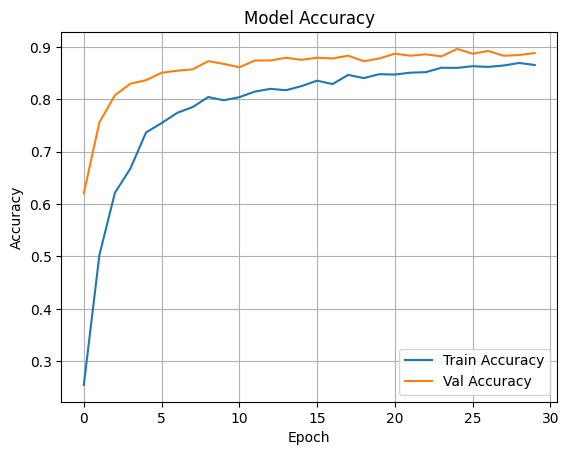

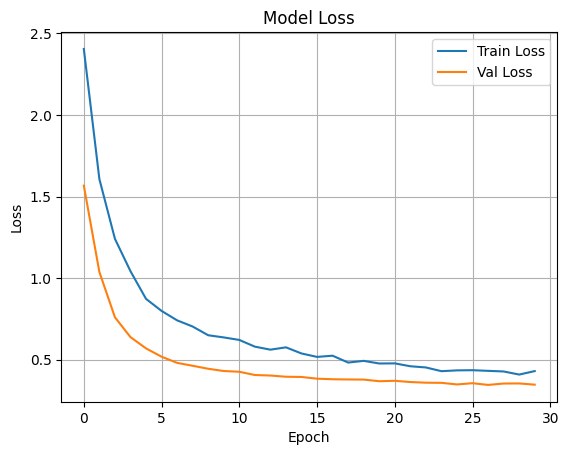

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Get correct class labels from the generator used during training
class_labels = list(train_generator.class_indices.keys())

# Check the number of classes
print(f"Number of classes detected: {len(class_labels)}")
print("Class labels:", class_labels)


Number of classes detected: 14
Class labels: ['ants', 'bees', 'beetle', 'caterpillar', 'earthworms', 'earwig', 'grasshopper', 'healthy', 'moth', 'slug', 'snail', 'train', 'wasp', 'weevil']


In [ ]:
print("Unique classes in y_true:", np.unique(y_true))
print("Number of unique classes:", len(np.unique(y_true)))


Unique classes in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Number of unique classes: 13


Classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Recheck class labels based on actual classes
class_labels = ['ants', 'bees', 'beetle', 'caterpillar', 'earthworms', 'earwig', 'grasshopper', 'healthy', 'moth', 'slug', 'snail', 'wasp', 'weevil']  # update if needed

# Print classification report
print("🔹 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


🔹 Classification Report:

              precision    recall  f1-score   support

        ants       0.85      0.97      0.91        60
        bees       0.95      0.97      0.96        60
      beetle       0.82      0.68      0.75        60
 caterpillar       0.80      0.73      0.77        60
  earthworms       0.82      0.90      0.86        50
      earwig       0.80      0.68      0.74        60
 grasshopper       0.87      0.80      0.83        60
     healthy       0.97      1.00      0.98        60
        moth       0.94      0.98      0.96        60
        slug       0.87      0.90      0.89        60
       snail       1.00      1.00      1.00        60
        wasp       0.94      0.98      0.96        60
      weevil       0.92      1.00      0.96        60

    accuracy                           0.89       770
   macro avg       0.89      0.89      0.89       770
weighted avg       0.89      0.89      0.89       770



Confusion matrix

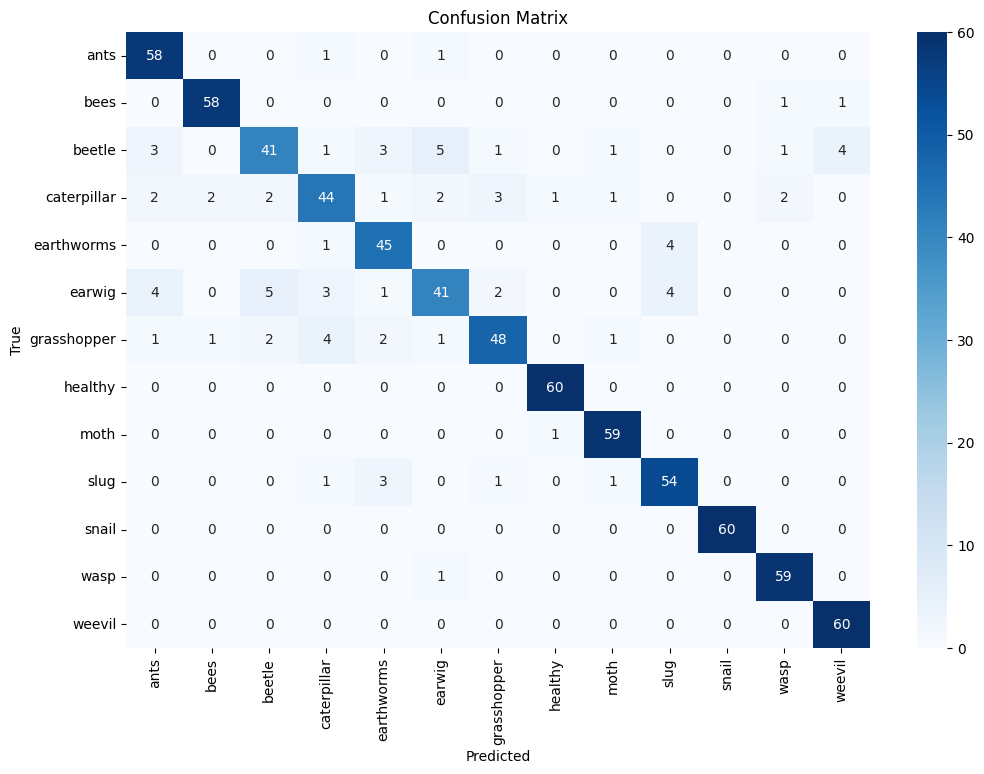

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Save the model

In [ ]:
# Save the trained model
model.save("final_pest_model.h5")
print("✅ Model saved as final_pest_model.h5")


✅ Model saved as final_pest_model.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("final_pest_model.h5")
print("✅ Model loaded successfully")


✅ Model loaded successfully


Predict the class

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


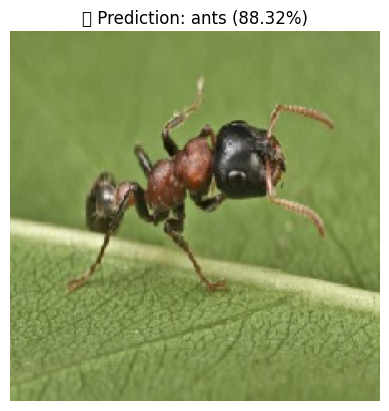

In [ ]:
# Step 1: Define the function
def classify_and_show(img_path, model, class_labels, threshold=0.7):
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing import image
    import numpy as np

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction)

    if confidence >= threshold:
        label = f"{class_labels[predicted_index]} ({confidence * 100:.2f}%)"
    else:
        label = f"Unidentified ({confidence * 100:.2f}%)"

    plt.imshow(img)
    plt.title(f"🔍 Prediction: {label}")
    plt.axis('off')
    plt.show()

# Step 2: Call the function
classify_and_show("/content/drive/MyDrive/Pest/Dataset/pest_dataset/ants/ants_6.jpg", model, class_labels)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the test set (usually without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Now you can define the test generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pest/Dataset/pest_dataset',       # Update the path if needed
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7692 images belonging to 15 classes.


Model inference/testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


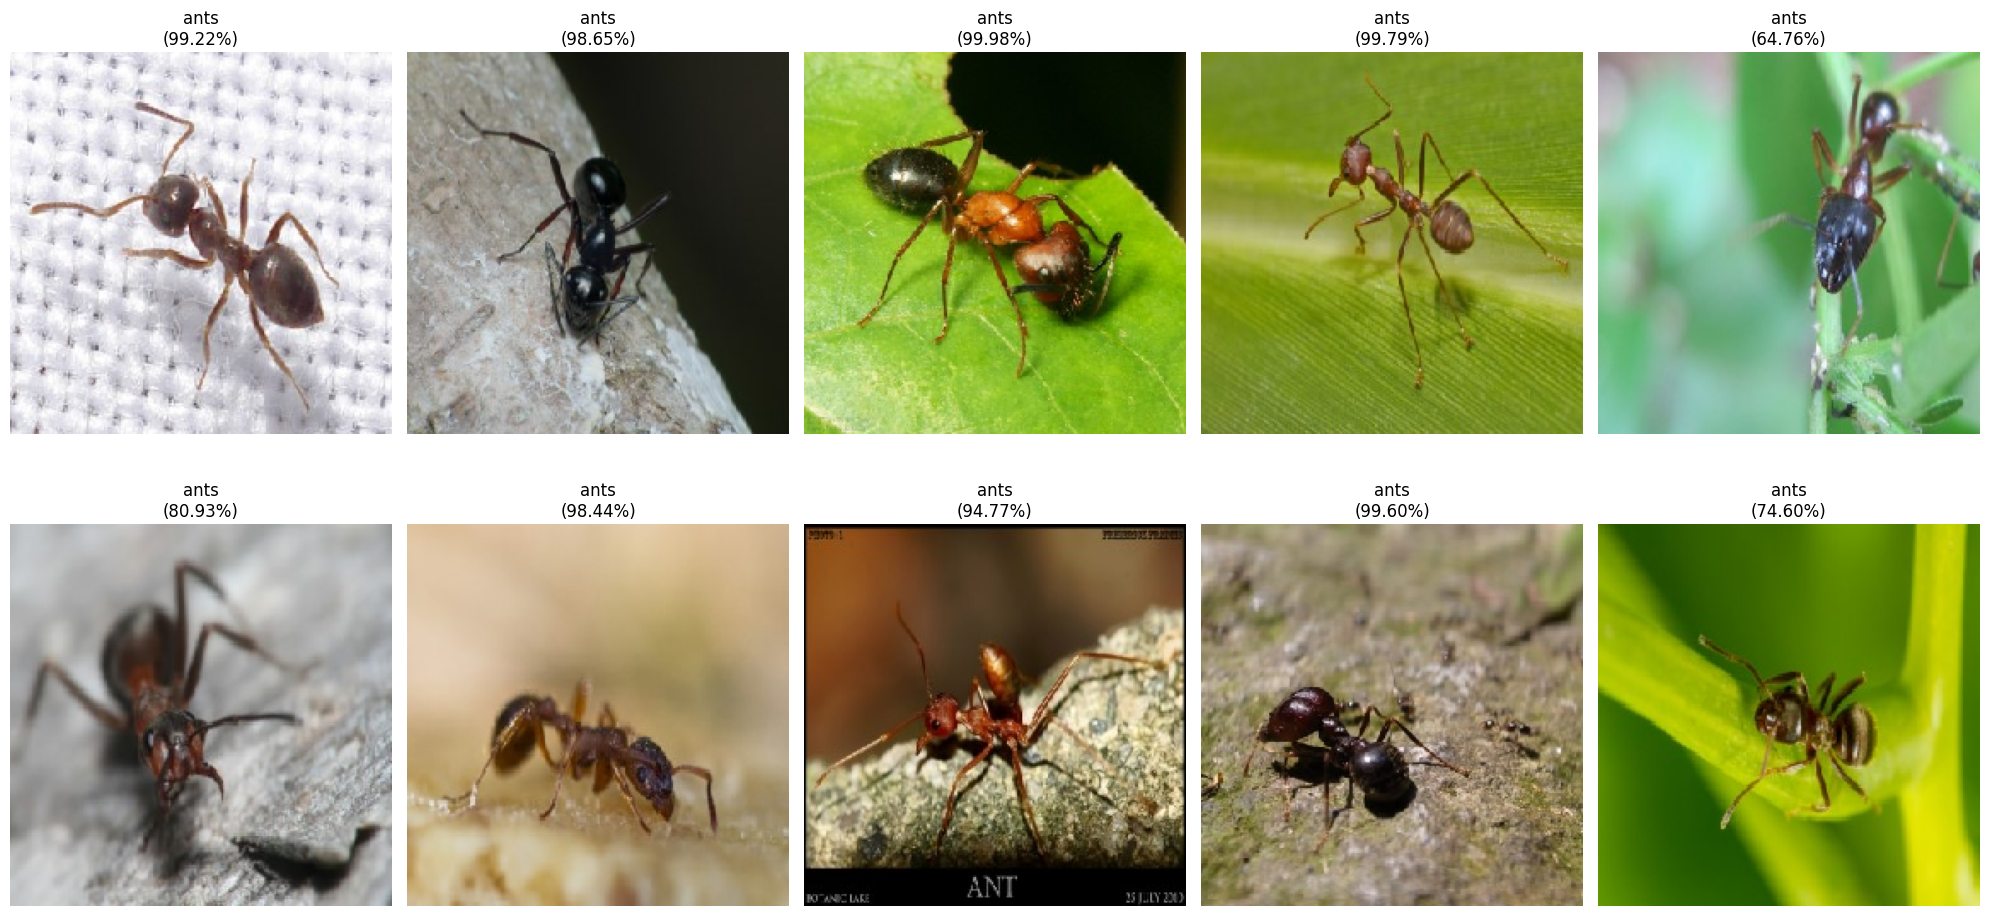

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Get batch of test images and labels
test_images, test_labels = next(test_generator)

# Predict
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)
confidences = np.max(pred_probs, axis=1)

# Define threshold below which to mark as 'Unidentified'
threshold = 0.5

# Map class indices to class names
class_indices = test_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Plot images with predictions
plt.figure(figsize=(20, 10))
for i in range(10):  # Show 10 samples
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')

    if confidences[i] < threshold:
        title = f"Unidentified\n({confidences[i]*100:.2f}%)"
    else:
        class_name = inv_class_indices[pred_classes[i]]
        title = f"{class_name}\n({confidences[i]*100:.2f}%)"

    plt.title(title, fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
import random

def create_test_set(source_dir, test_dir, num_images=5):
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    class_names = os.listdir(source_dir)

    for class_name in class_names:
        src_class_path = os.path.join(source_dir, class_name)
        dst_class_path = os.path.join(test_dir, class_name)

        if not os.path.exists(dst_class_path):
            os.makedirs(dst_class_path)

        files = os.listdir(src_class_path)
        selected_files = random.sample(files, min(num_images, len(files)))

        for file in selected_files:
            shutil.copy(os.path.join(src_class_path, file), os.path.join(dst_class_path, file))

# Example usage:
create_test_set('/content/drive/MyDrive/Pest/Dataset/pest_dataset/train', '/content/drive/MyDrive/Pest/Dataset/pest_dataset/test', num_images=10)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the test set (usually without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Now you can define the test generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Pest/Dataset/pest_dataset/test',       # Update the path if needed
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 246 images belonging to 14 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


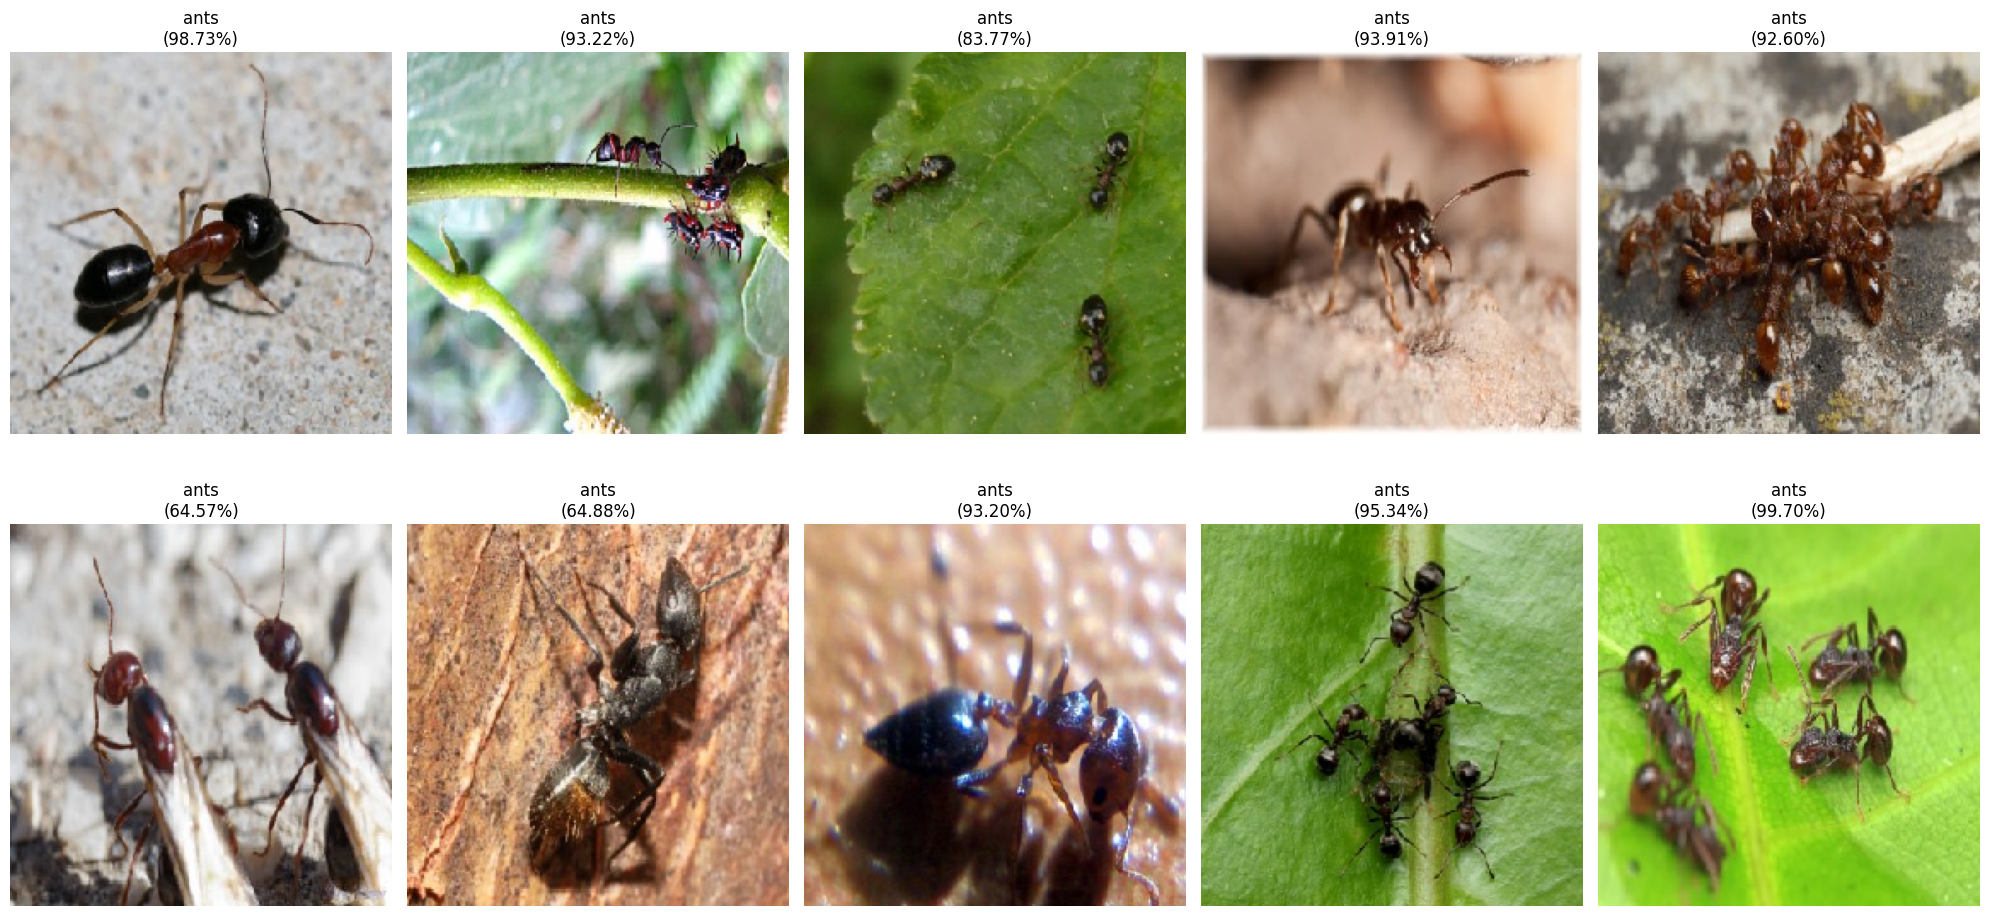

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Get batch of test images and labels
test_images, test_labels = next(test_generator)

# Predict
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)
confidences = np.max(pred_probs, axis=1)

# Define threshold below which to mark as 'Unidentified'
threshold = 0.5

# Map class indices to class names
class_indices = test_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Plot images with predictions
plt.figure(figsize=(20, 10))
for i in range(10):  # Show 10 samples
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')

    if confidences[i] < threshold:
        title = f"Unidentified\n({confidences[i]*100:.2f}%)"
    else:
        class_name = inv_class_indices[pred_classes[i]]
        title = f"{class_name}\n({confidences[i]*100:.2f}%)"

    plt.title(title, fontsize=12)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


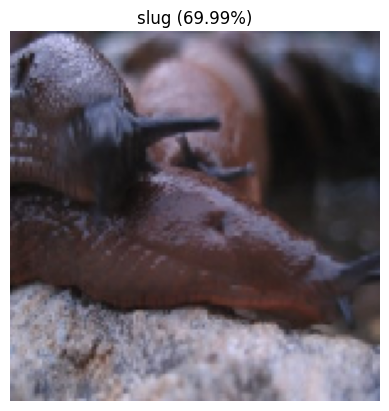

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


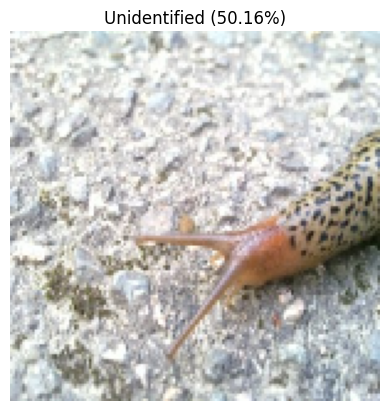

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


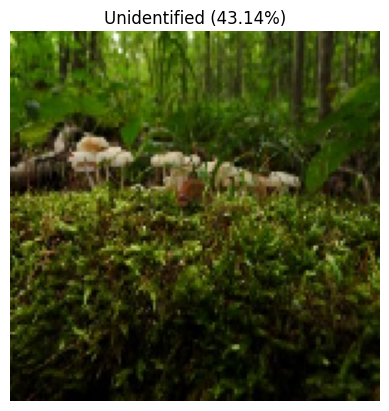

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


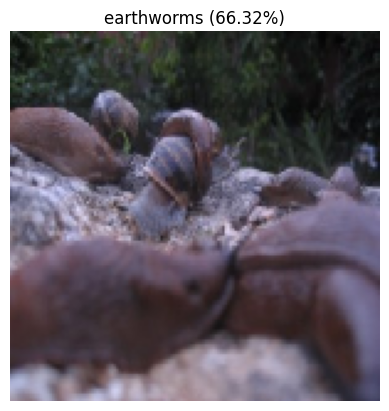

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


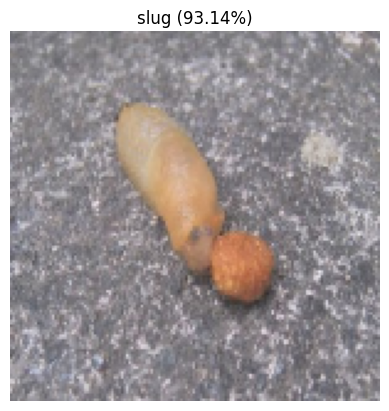

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


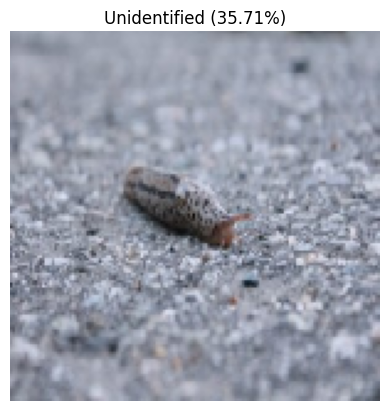

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


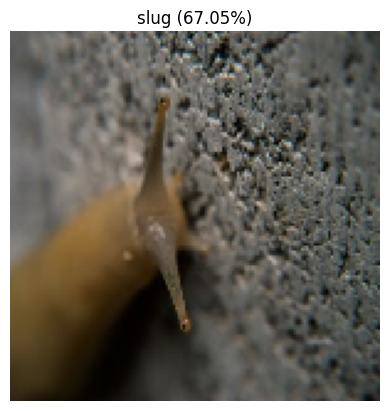

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


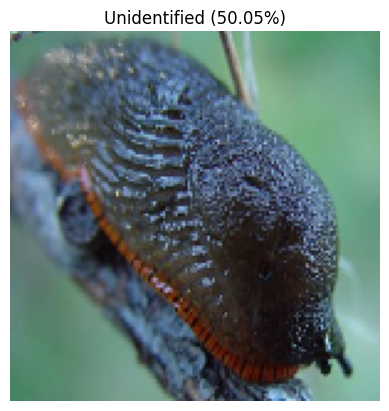

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


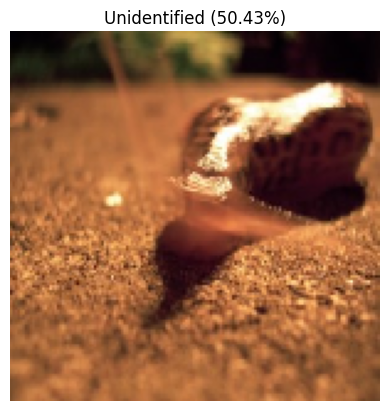

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


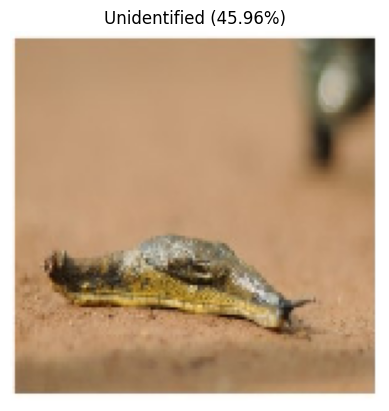

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load trained model
model = load_model('/content/drive/MyDrive/Pest/final_pest_model.keras')

# Define class labels
class_labels = [
    'ants', 'bees', 'beetle', 'caterpillar', 'earthworms', 'earwig',
    'grasshopper', 'healthy', 'moth', 'slug', 'snail', 'train', 'wasp', 'weevil'
]

# Set the test directory
test_dir = '/content/drive/MyDrive/Pest/Dataset/pest_dataset/test'

# Collect image paths
image_paths = []
for class_name in os.listdir(test_dir):
    class_folder = os.path.join(test_dir, class_name)
    if os.path.isdir(class_folder):
        for fname in os.listdir(class_folder):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_folder, fname))

# Show predictions for first 10 images
for img_path in image_paths[:10]:
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to match model's input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    preds = model.predict(img_array)[0]
    top_idx = np.argmax(preds)
    confidence = preds[top_idx]

    label = class_labels[top_idx] if confidence >= 0.60 else "Unidentified"

    # Plot the result
    plt.imshow(img)
    plt.title(f"{label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()


In [ ]:
import pandas as pd

# List to hold prediction data
prediction_data = []

# Loop through test images and collect predictions
for img_path in image_paths:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    preds = model.predict(img_array)[0]
    top_idx = np.argmax(preds)
    confidence = preds[top_idx]

    if confidence < 0.60:
        label = "Unidentified"
    else:
        label = class_labels[top_idx]

    prediction_data.append({
        'image_name': os.path.basename(img_path),
        'predicted_label': label,
        'confidence (%)': f"{confidence * 100:.2f}"
    })

# Convert to DataFrame
df = pd.DataFrame(prediction_data)

# Save to CSV
csv_path = '/content/drive/MyDrive/Pest/predictions.csv'
df.to_csv(csv_path, index=False)

print(f"✅ Predictions saved to {csv_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━

Found 246 images belonging to 14 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


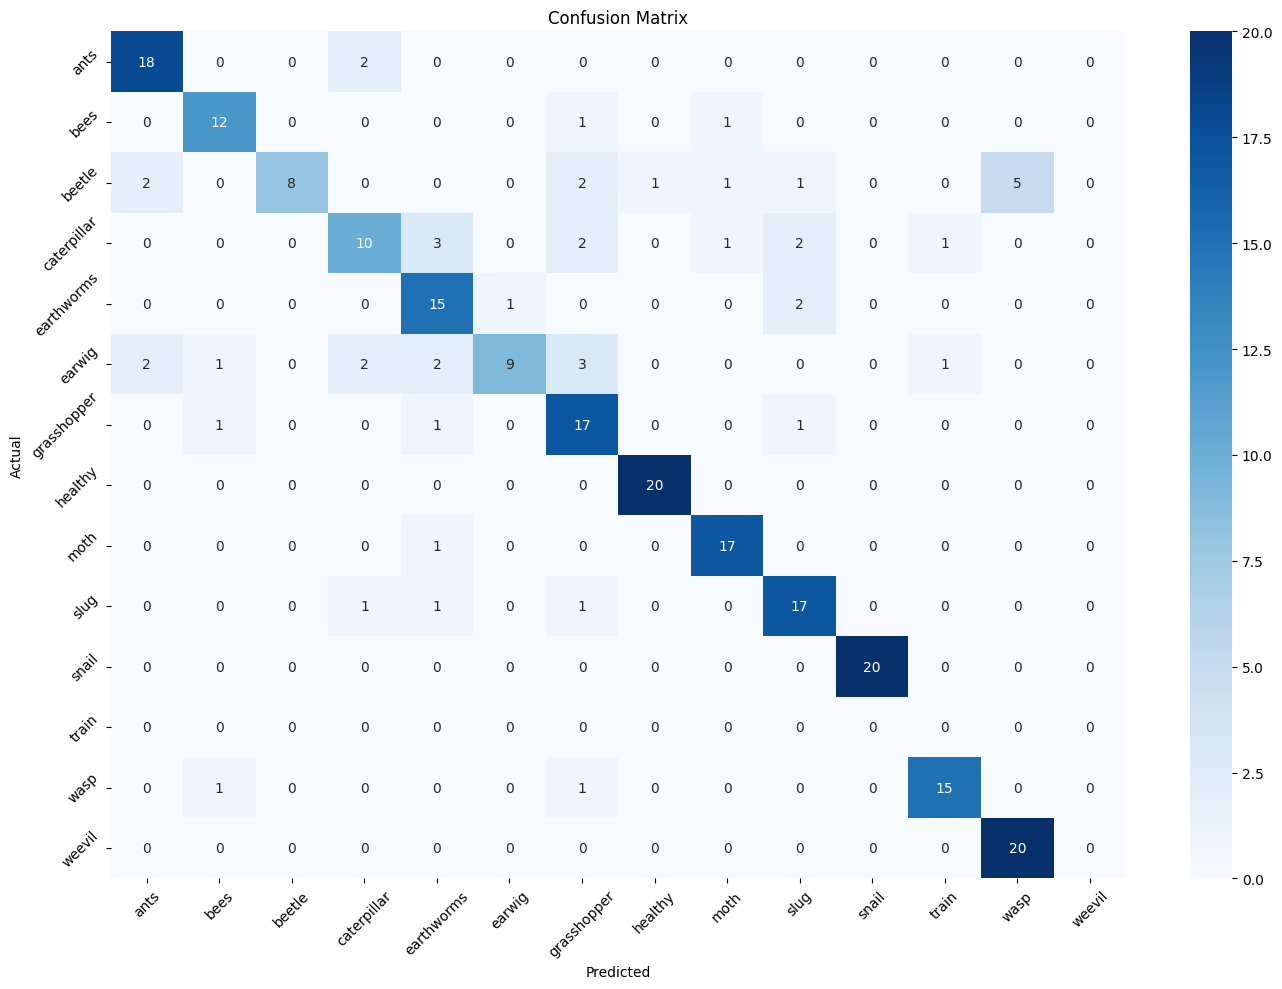


Classification Report:

              precision    recall  f1-score   support

        ants       0.82      0.90      0.86        20
        bees       0.80      0.86      0.83        14
      beetle       1.00      0.40      0.57        20
 caterpillar       0.67      0.53      0.59        19
  earthworms       0.65      0.83      0.73        18
      earwig       0.90      0.45      0.60        20
 grasshopper       0.63      0.85      0.72        20
     healthy       0.95      1.00      0.98        20
        moth       0.85      0.94      0.89        18
        slug       0.74      0.85      0.79        20
       snail       1.00      1.00      1.00        20
       train       0.00      0.00      0.00         0
        wasp       0.00      0.00      0.00        17
      weevil       0.00      0.00      0.00        20

    accuracy                           0.66       246
   macro avg       0.64      0.62      0.61       246
weighted avg       0.70      0.66      0.66       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load test dataset using flow_from_directory
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with correct image size
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # 👈 Change this to match model input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# Predict using model
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

# Plotting
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


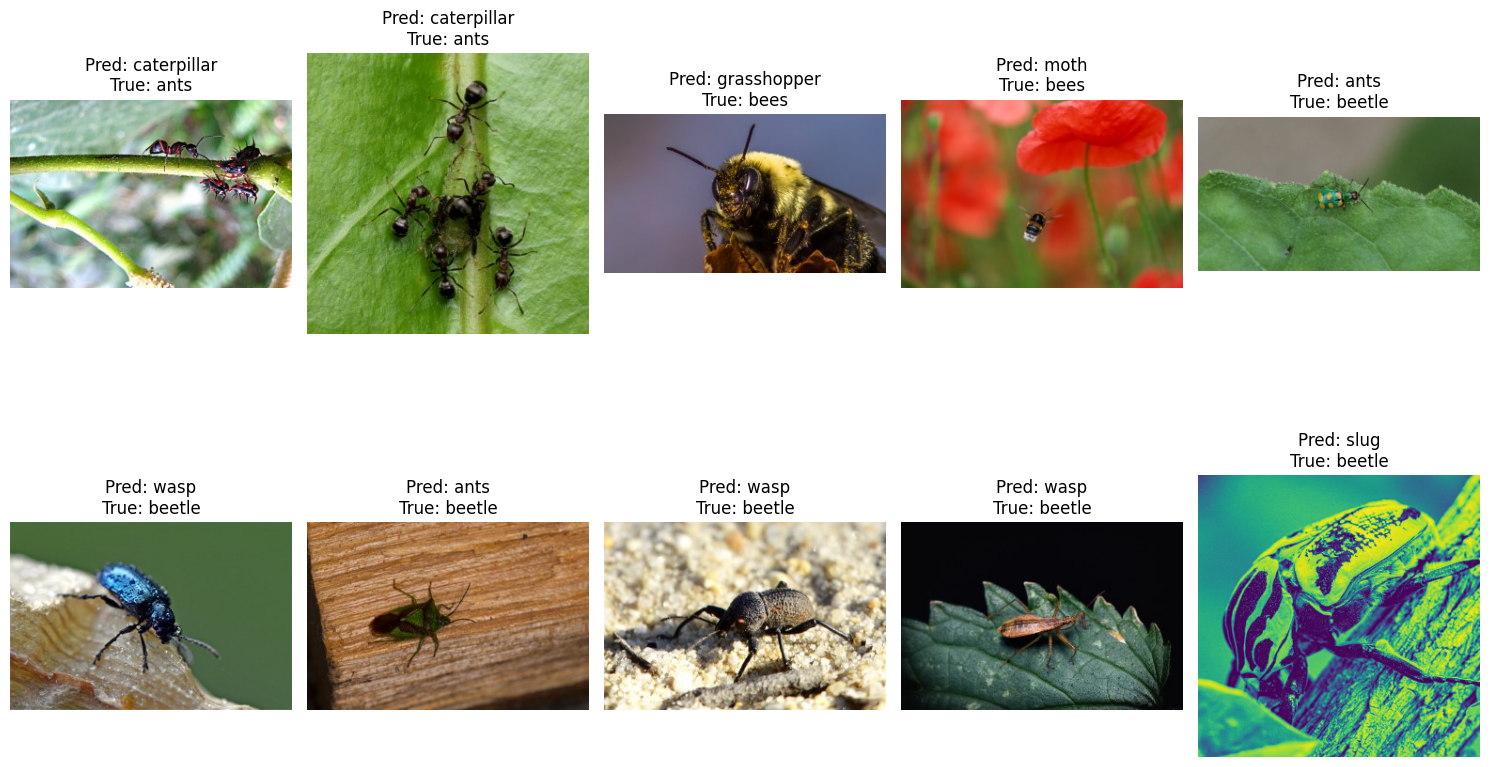

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the predicted and true labels
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Get file paths of test images
file_paths = test_generator.filepaths

# Identify misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

# Plot some misclassified images
num_images = min(10, len(misclassified_indices))
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_images]):
    img = plt.imread(file_paths[idx])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_labels[y_pred[idx]]}\nTrue: {class_labels[y_true[idx]]}")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

        ants       0.82      0.90      0.86        20
        bees       0.80      0.86      0.83        14
      beetle       1.00      0.40      0.57        20
 caterpillar       0.67      0.53      0.59        19
  earthworms       0.65      0.83      0.73        18
      earwig       0.90      0.45      0.60        20
 grasshopper       0.63      0.85      0.72        20
     healthy       0.95      1.00      0.98        20
        moth       0.85      0.94      0.89        18
        slug       0.74      0.85      0.79        20
       snail       1.00      1.00      1.00        20
       train       0.00      0.00      0.00         0
        wasp       0.00      0.00      0.00        17
      weevil       0.00      0.00      0.00        20

    accuracy                           0.66       246
   macro avg       0.64      0.62      0.61       246
weighted avg       0.70      0.66      0.66       246



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

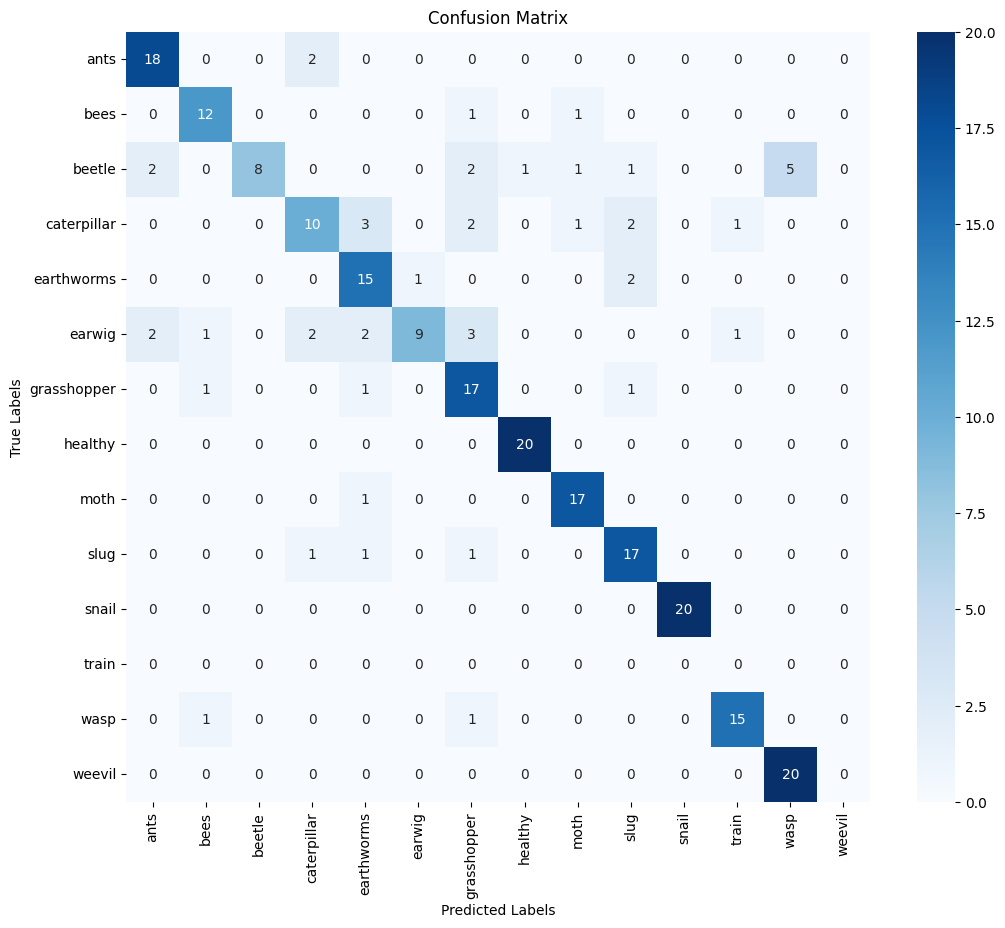

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("my_pest_model.h5")
print("✅ Model saved")

✅ Model saved


In [ ]:
from google.colab import drive
import os
from tensorflow.keras.models import load_model

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define and create save directory
save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)

# Step 3: Save your model (replace `model` with your model's variable name)
model.save(os.path.join(save_dir, 'final_pest_model.h5'))

print(f"✅ Model saved at: {os.path.join(save_dir, 'final_pest_model.h5')}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved at: /content/drive/MyDrive/saved_models/final_pest_model.h5
